# **Anchor Google Drive file system**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import libraries**

In [4]:
import pytz
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# **Global definitions**

In [5]:
input_dir = "/content/drive/MyDrive/AD_SMART_CITY/AD/Input/"
output_dir = "/content/drive/MyDrive/AD_SMART_CITY/AD/Output/"
output_models_dir = output_dir + "Models/"
output_forecasts_dir = output_dir + "Forecasts/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEQ_LENGTH = 100
BATCH_SIZE = 256
HIDDEN_DIM = 10
DROPOUT_RATE = 0.0
NUM_EPOCHS = 100

# **Functions and classes**

In [6]:
class PMDatasetM2MLSTM(Dataset):
  def __init__(self, list_of_arrays, seq_length):
    self.samples = []
    for arr in list_of_arrays:
      for i in range(len(arr) - seq_length):
        x = arr[i:i+seq_length]
        y = arr[i+1:i+seq_length+1]
        self.samples.append((x.reshape(-1,1), y.reshape(-1,1)))
  def __len__(self):
    return len(self.samples)
  def __getitem__(self, idx):
    return torch.tensor(self.samples[idx][0], dtype=torch.float32), \
    torch.tensor(self.samples[idx][1], dtype=torch.float32)

class PMDatasetSeq2OneLSTM(Dataset):
  def __init__(self, list_of_day_arrays, seq_length):
    self.samples = []
    for day_array in list_of_day_arrays:
      day_array = day_array.flatten()  # ensure 1D
      for i in range(len(day_array) - seq_length):
        x = day_array[i:i+seq_length]      # input sequence
        y = day_array[i+seq_length]        # next step
        self.samples.append((x.reshape(-1,1), [y]))  # x: (seq_len,1), y: (1,)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    x, y = self.samples[idx]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class Seq2OneLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size=1, num_layers=1, dropout=0.0):
    super(Seq2OneLSTM, self).__init__()
    self.lstm = nn.LSTM(
      input_size, hidden_size, num_layers=num_layers,
      batch_first=True, dropout=dropout
    )
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, (hidden, cell) = self.lstm(x)
    last_hidden = lstm_out[:, -1, :]
    out = self.fc(last_hidden)
    return out


# We are not using this
class M2MLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_rate, output_dim):
    super(M2MLSTMModel, self).__init__()
    self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    self.fc = nn.Linear(hidden_size, output_dim)

  def forward(self, x):
    x, _ = self.lstm1(x)
    x = self.dropout1(x)
    x = self.fc(x)
    return x

# **Load the Data**

In [7]:
# Caricamento dati

fault_free_data = {}
faulty_data = {}

fault_free_data["N"] = {}
fault_free_data["A"] = {}
faulty_data["N"] = {}
faulty_data["A"] = {}

for dataset in os.listdir(input_dir):
  print(dataset)
  if os.path.isdir(input_dir + dataset) and dataset != ".ipynb_checkpoints":
    time_frame = dataset.split("_")[-1]
    fault_free_data["N"][time_frame] = {}
    fault_free_data["A"][time_frame] = {}
    faulty_data["N"][time_frame] = {}
    faulty_data["A"][time_frame] = {}

    # loading normal data

    for day in os.listdir(input_dir + dataset + "/board_0/Normal/"):
      if dataset != ".ipynb_checkpoints":
        fault_free_data["N"][time_frame][day.split(".")[0]] = pd.read_csv(input_dir + dataset + "/board_0/Normal/" + day)
        faulty_data["N"][time_frame][day.split(".")[0]] = pd.read_csv(input_dir + dataset + "/board_13/Normal/" + day)

    # loading anomalous data

    for day in os.listdir(input_dir + dataset + "/board_0/Anomalous/"):
      if dataset != ".ipynb_checkpoints":
        fault_free_data["A"][time_frame][day.split(".")[0]] = pd.read_csv(input_dir + dataset + "/board_0/Anomalous/" + day)
        faulty_data["A"][time_frame][day.split(".")[0]] = pd.read_csv(input_dir + dataset + "/board_13/Anomalous/" + day)

  print("L'intervallo e': " + time_frame)
  print("I giorni normali (fault-free) sono: ")
  print(list(fault_free_data["N"][time_frame].keys()))
  print("I giorni normali (faulty) sono: ")
  print(list(faulty_data["N"][time_frame].keys()))
  print("I giorni anomali (fault-free) sono: ")
  print(list(fault_free_data["A"][time_frame].keys()))
  print("I giorni anomali (faulty) sono: ")
  print(list(faulty_data["A"][time_frame].keys()))



11_17-21
L'intervallo e': 17-21
I giorni normali (fault-free) sono: 
['3_November', '5_November', '7_November', '16_November', '10_November', '24_November', '12_November', '23_November', '1_November', '14_November', '4_November', '29_November']
I giorni normali (faulty) sono: 
['3_November', '5_November', '7_November', '16_November', '10_November', '24_November', '12_November', '23_November', '1_November', '14_November', '4_November', '29_November']
I giorni anomali (fault-free) sono: 
['2_November', '27_November', '15_November', '28_November']
I giorni anomali (faulty) sono: 
['2_November', '27_November', '15_November', '28_November']
11_5-8
L'intervallo e': 5-8
I giorni normali (fault-free) sono: 
['7_November', '9_November', '18_November', '23_November', '10_November', '11_November', '22_November', '30_November', '24_November', '15_November', '3_November', '14_November']
I giorni normali (faulty) sono: 
['7_November', '9_November', '18_November', '23_November', '10_November', '11_No

# **Build normal training, normal test and anomalous days sets**

In [8]:
normal_training_days = {}
normal_test_days = {}
anomalous_days = {}

for time_frame in fault_free_data["N"]:
  normal_training_days[time_frame] = None
  normal_test_days[time_frame] = None
  anomalous_days[time_frame] = None

  normal_days = list(fault_free_data["N"][time_frame].keys())
  normal_training_days[time_frame], normal_test_days[time_frame] = train_test_split(normal_days, test_size=0.5)
  anomalous_days[time_frame] = list(fault_free_data["A"][time_frame].keys())


# **Train and save LSTM models for each time frame**

In [ ]:
LSTM_models = {}
loss_list = {}
scalers = {}


for time_frame in normal_training_days:
  LSTM_models[time_frame] = None
  loss_list[time_frame] = []
  # preparing the training dataset
  train_dataset = []
  for day in normal_training_days[time_frame]:
    train_dataset.append(np.array(fault_free_data["N"][time_frame][day]["pm25_calibrated"]))
  scalers[time_frame] = MinMaxScaler()
  scalers[time_frame].fit(train_dataset)
  train_dataset = scalers[time_frame].transform(train_dataset)
  train_dataset = PMDatasetSeq2OneLSTM(train_dataset, SEQ_LENGTH)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

  # preparing the LSTM model for training
  x_sample, y_sample = train_dataset[0]
  INPUT_DIM = x_sample.shape[1]
  criterion = nn.MSELoss()
  LSTM_models[time_frame] = Seq2OneLSTM(INPUT_DIM, HIDDEN_DIM).to(device)
  optimizer = torch.optim.Adam(LSTM_models[time_frame].parameters(), lr=0.001)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
  LSTM_models[time_frame].train()

  # training the LSTM model
  print("Training the LSTM for time frame: " + time_frame)
  for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = LSTM_models[time_frame](inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    loss_list[time_frame].append(epoch_loss)
    scheduler.step(epoch_loss)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}')

  torch.save(LSTM_models[time_frame].state_dict(), output_models_dir + time_frame + ".pth")

Training the LSTM for time frame: 17-21
Epoch [1/100], Loss: 0.0536
Epoch [2/100], Loss: 0.0091
Epoch [3/100], Loss: 0.0019
Epoch [4/100], Loss: 0.0014
Epoch [5/100], Loss: 0.0012
Epoch [6/100], Loss: 0.0011
Epoch [7/100], Loss: 0.0010
Epoch [8/100], Loss: 0.0009
Epoch [9/100], Loss: 0.0008
Epoch [10/100], Loss: 0.0007
Epoch [11/100], Loss: 0.0007
Epoch [12/100], Loss: 0.0006
Epoch [13/100], Loss: 0.0006
Epoch [14/100], Loss: 0.0006
Epoch [15/100], Loss: 0.0006
Epoch [16/100], Loss: 0.0005
Epoch [17/100], Loss: 0.0005
Epoch [18/100], Loss: 0.0005
Epoch [19/100], Loss: 0.0005
Epoch [20/100], Loss: 0.0004
Epoch [21/100], Loss: 0.0004
Epoch [22/100], Loss: 0.0004
Epoch [23/100], Loss: 0.0004
Epoch [24/100], Loss: 0.0004
Epoch [25/100], Loss: 0.0004
Epoch [26/100], Loss: 0.0004
Epoch [27/100], Loss: 0.0004
Epoch [28/100], Loss: 0.0004
Epoch [29/100], Loss: 0.0004
Epoch [30/100], Loss: 0.0003
Epoch [31/100], Loss: 0.0003
Epoch [32/100], Loss: 0.0003
Epoch [33/100], Loss: 0.0003
Epoch [34/10

# **Load LSTM models**

In [9]:
scalers = {}
for time_frame in normal_training_days:
  train_dataset = []
  for day in normal_training_days[time_frame]:
    train_dataset.append(np.array(fault_free_data["N"][time_frame][day]["pm25_calibrated"]))
  scalers[time_frame] = MinMaxScaler()
  scalers[time_frame].fit(train_dataset)

LSTM_models = {}
for time_frame in os.listdir(output_models_dir):
  LSTM_models[time_frame.split(".")[0]] = Seq2OneLSTM(1, HIDDEN_DIM).to(device)
  LSTM_models[time_frame.split(".")[0]].load_state_dict(torch.load(output_models_dir + time_frame))


# **Display loss (optional)**




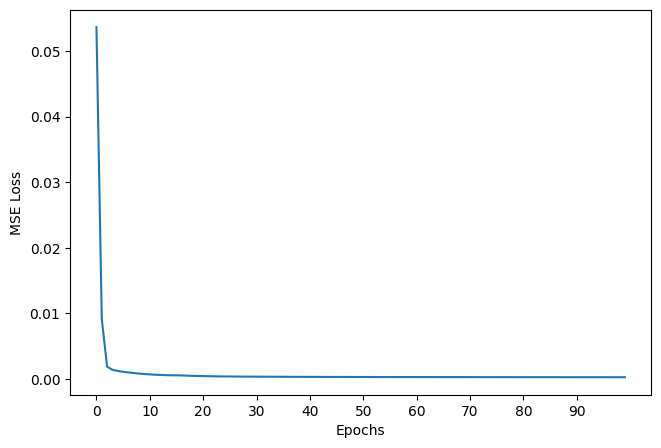

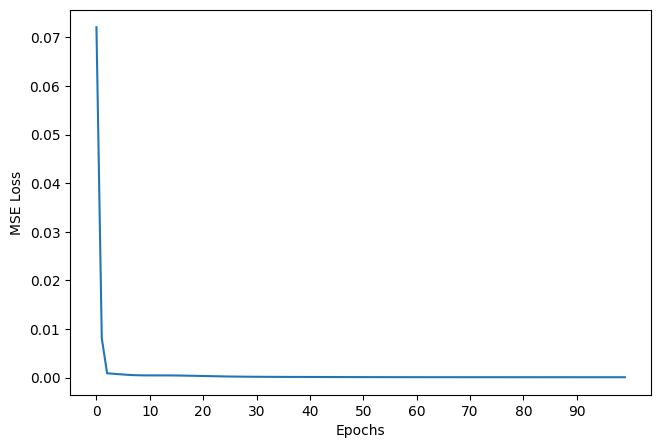

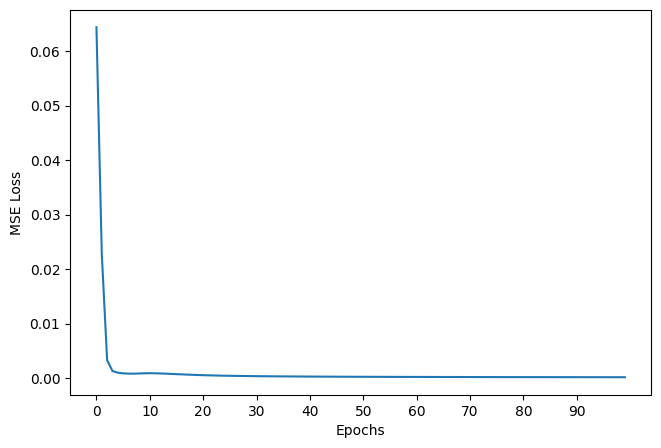

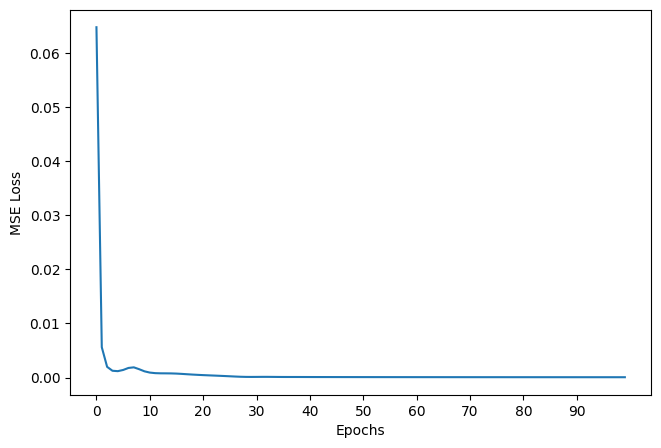

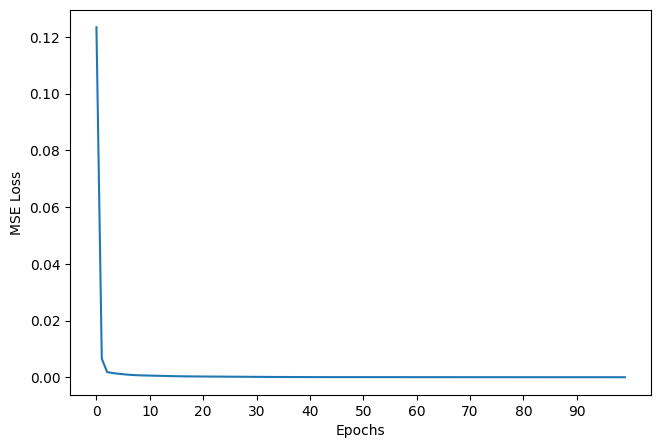

In [ ]:
for time_frame in loss_list:
  fig = plt.figure(figsize=(7.5,5))
  plt.plot(loss_list[time_frame])
  plt.xlabel("Epochs")
  plt.ylabel("MSE Loss")
  step = max(1, len(loss_list[time_frame]) // 10)
  plt.xticks(np.arange(0, len(loss_list[time_frame]), step))
  plt.show()
  plt.close(fig)

# **Verify prediction (optional)**

In [ ]:
time_frame = "5-8"
day = "23_November"

verification_dataset = [np.array(fault_free_data["N"][time_frame][day]["pm25_calibrated"])]
day_data_length = len(verification_dataset[0])
verification_dataset = scalers[time_frame].transform(verification_dataset)

forecast = []

steps_remaining = day_data_length - SEQ_LENGTH
step_number = 0

LSTM_models[time_frame].eval()

while steps_remaining > 0:
  if step_number+SEQ_LENGTH < day_data_length:
    input_seq = verification_dataset[0][step_number:step_number+SEQ_LENGTH].astype(np.float32)
  else:
    input_seq = verification_dataset[0][step_number:day_data_length].astype(np.float32)
  input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0)
  pred = LSTM_models[time_frame](input_seq)
  forecast.append(pred.flatten().detach().numpy().item())

  input_seq = input_seq.flatten().detach().numpy()
  input_seq = input_seq[1:]
  input_seq = np.append(input_seq, pred.flatten().detach().numpy().item()).astype(np.float32)
  input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0)
  steps_remaining -= 1
  step_number = step_number + 1

concatenated_initial_seq_forecast = [np.concatenate([verification_dataset[0][:SEQ_LENGTH], forecast])]
mse = np.mean((concatenated_initial_seq_forecast - verification_dataset[0]) ** 2)


# **Forecast F+A PM25 test normal and anomalous days**

In [10]:
mse = {}
mse["F+A"] = {}
if not os.path.exists(output_forecasts_dir + "F+A"):
  os.mkdir(output_forecasts_dir + "F+A")


for time_frame in normal_test_days:
  if not os.path.exists(output_forecasts_dir + "F+A/" + time_frame):
    os.mkdir(output_forecasts_dir + "F+A/" + time_frame)
    os.mkdir(output_forecasts_dir + "F+A/" + time_frame + "/N")
    os.mkdir(output_forecasts_dir + "F+A/" + time_frame + "/A")

  mse["F+A"][time_frame] = {}

  # forecast normal days and memorize mse
  mse["F+A"][time_frame]["N"] = {}
  normal_test_dataset = []
  for day in normal_test_days[time_frame]:
    normal_test_dataset.append(np.array(faulty_data["N"][time_frame][day]["pm25_calibrated"]))

  min_len = min(len(arr) for arr in normal_test_dataset)
  normal_test_dataset = np.stack([arr[:min_len] for arr in normal_test_dataset])
  normal_test_dataset = scalers[time_frame].transform(normal_test_dataset)

  print("Normal days of time frame " + time_frame)
  for idx,day in enumerate(normal_test_dataset):
    day_data_length = len(day)
    LSTM_models[time_frame].eval()
    forecast = []
    steps_remaining = day_data_length - SEQ_LENGTH
    step_number = 0
    LSTM_models[time_frame].eval()
    while steps_remaining > 0:
      if step_number+SEQ_LENGTH < day_data_length:
        input_seq = day[step_number:step_number+SEQ_LENGTH].astype(np.float32)
      else:
        input_seq = day[step_number:day_data_length].astype(np.float32)
      input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
      pred = LSTM_models[time_frame](input_seq)
      forecast.append(pred.flatten().detach().cpu().numpy().item())
      input_seq = input_seq.flatten().detach().cpu().numpy()
      input_seq = input_seq[1:]
      input_seq = np.append(input_seq, pred.flatten().detach().cpu().numpy().item()).astype(np.float32)
      input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
      steps_remaining -= 1
      step_number = step_number + 1

    unnormalized_day = scalers[time_frame].inverse_transform([day])[0]
    unnormalized_forecast = scalers[time_frame].inverse_transform([np.concatenate([day[:SEQ_LENGTH], forecast])])[0]

    actual_predicted_df = pd.DataFrame(columns=["pm25_calibrated", "pm25_calibrated_predicted"])
    actual_predicted_df["pm25_calibrated"] = unnormalized_day
    actual_predicted_df["pm25_calibrated_predicted"] = unnormalized_forecast
    actual_predicted_df.to_csv(output_forecasts_dir + "F+A/" + time_frame + "/N/" + normal_test_days[time_frame][idx] + ".csv", index=False)
    temp_mse = np.mean((unnormalized_day - unnormalized_forecast) ** 2)
    mse["F+A"][time_frame]["N"][normal_test_days[time_frame][idx]] = temp_mse
    print("day " + normal_test_days[time_frame][idx] + " MSE:" + str(temp_mse))
    '''
    #actual_predicted_df[['pm25_calibrated', 'pm25_calibrated_predicted']].plot(figsize=(10, 5))
    plt.title("Feature 1 vs Feature 2 over index")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()
    '''
  mse_file = open(output_forecasts_dir + "F+A/" + time_frame + "/N/mse.txt", "w")
  for idx,day in enumerate(mse["F+A"][time_frame]["N"]):
    if idx < len(mse["F+A"][time_frame]["N"]) - 1:
      mse_file.write(day + ": " + str(mse["F+A"][time_frame]["N"][day]) + "\n")
    else:
      mse_file.write(day + ": " + str(mse["F+A"][time_frame]["N"][day]))
  mse_file.close()

  # forecast anomalous days and memorize mse
  mse["F+A"][time_frame]["A"] = {}
  anomalous_dataset = []
  for day in anomalous_days[time_frame]:
    anomalous_dataset.append(np.array(faulty_data["A"][time_frame][day]["pm25_calibrated"]))

  min_len = min(len(arr) for arr in anomalous_dataset)
  anomalous_dataset = np.stack([arr[:min_len] for arr in anomalous_dataset])
  anomalous_dataset = scalers[time_frame].transform(anomalous_dataset)

  print("Anomalous days of time frame " + time_frame)
  for idx,day in enumerate(anomalous_dataset):
    day_data_length = len(day)
    LSTM_models[time_frame].eval()
    forecast = []
    steps_remaining = day_data_length - SEQ_LENGTH
    step_number = 0
    LSTM_models[time_frame].eval()

    while steps_remaining > 0:
      if step_number+SEQ_LENGTH < day_data_length:
        input_seq = day[step_number:step_number+SEQ_LENGTH].astype(np.float32)
      else:
        input_seq = day[step_number:day_data_length].astype(np.float32)
      input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
      pred = LSTM_models[time_frame](input_seq)
      forecast.append(pred.flatten().detach().cpu().numpy().item())
      input_seq = input_seq.flatten().detach().cpu().numpy()
      input_seq = input_seq[1:]
      input_seq = np.append(input_seq, pred.flatten().detach().cpu().numpy().item()).astype(np.float32)
      input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
      steps_remaining -= 1
      step_number = step_number + 1

    unnormalized_day = scalers[time_frame].inverse_transform([day])[0]
    unnormalized_forecast = scalers[time_frame].inverse_transform([np.concatenate([day[:SEQ_LENGTH], forecast])])[0]

    actual_predicted_df = pd.DataFrame(columns=["pm25_calibrated", "pm25_calibrated_predicted"])
    actual_predicted_df["pm25_calibrated"] = unnormalized_day
    actual_predicted_df["pm25_calibrated_predicted"] = unnormalized_forecast
    actual_predicted_df.to_csv(output_forecasts_dir + "F+A/" + time_frame + "/A/" + anomalous_days[time_frame][idx] + ".csv", index=False)
    temp_mse = np.mean((unnormalized_day - unnormalized_forecast) ** 2)
    mse["F+A"][time_frame]["A"][anomalous_days[time_frame][idx]] = temp_mse
    print("day " + anomalous_days[time_frame][idx] + " MSE:" + str(temp_mse))
    '''
    #actual_predicted_df[['pm25_calibrated', 'pm25_calibrated_predicted']].plot(figsize=(10, 5))
    plt.title("Feature 1 vs Feature 2 over index")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()
    '''
  mse_file = open(output_forecasts_dir + "F+A/" + time_frame + "/A/mse.txt", "w")
  for idx,day in enumerate(mse["F+A"][time_frame]["A"]):
    if idx < len(mse["F+A"][time_frame]["A"]) - 1:
      mse_file.write(day + ": " + str(mse["F+A"][time_frame]["A"][day]) + "\n")
    else:
      mse_file.write(day + ": " + str(mse["F+A"][time_frame]["A"][day]))
  mse_file.close()


Normal days of time frame 17-21
day 14_November MSE:0.030895185800870854
day 3_November MSE:0.9075948173276916
day 5_November MSE:0.18109469536678563
day 4_November MSE:0.10322671068393123
day 7_November MSE:0.028140996071249036
day 10_November MSE:0.06805447226593071
Anomalous days of time frame 17-21
day 2_November MSE:1.7728587793722892
day 27_November MSE:20.26363339565769
day 15_November MSE:35.39971274998403
day 28_November MSE:12.854978213239264
Normal days of time frame 5-8
day 24_November MSE:0.01152201351651905
day 14_November MSE:0.051881983915905
day 9_November MSE:0.08296712501323025
day 11_November MSE:0.11310258007153653
day 18_November MSE:0.0187960114585747
day 3_November MSE:0.09547850161436726
Anomalous days of time frame 5-8
day 2_November MSE:0.0804208769346492
day 16_November MSE:21.72749188491772
day 12_November MSE:5.488631268115489
day 27_November MSE:2.815224620457245
Normal days of time frame 8-13
day 11_November MSE:8.803048844008647
day 10_November MSE:7.85

# **Forecast PM25_{1..4} test normal and anomalous days**

In [12]:
individual_sensor_labels = ["pm25_0", "pm25_1", "pm25_2", "pm25_3"]

for sensor_label in individual_sensor_labels:
  mse[sensor_label] = {}
  if not os.path.exists(output_forecasts_dir + sensor_label):
    os.mkdir(output_forecasts_dir + sensor_label)
  for time_frame in normal_test_days:
    if not os.path.exists(output_forecasts_dir + sensor_label + "/" + time_frame):
      os.mkdir(output_forecasts_dir + sensor_label + "/" + time_frame)
      os.mkdir(output_forecasts_dir + sensor_label + "/" + time_frame + "/N")
      os.mkdir(output_forecasts_dir + sensor_label + "/" + time_frame + "/A")

    mse[sensor_label][time_frame] = {}

    # forecast normal days and memorize mse
    mse[sensor_label][time_frame]["N"] = {}
    normal_test_dataset = []
    for day in normal_test_days[time_frame]:
      normal_test_dataset.append(np.array(faulty_data["N"][time_frame][day][sensor_label + "_calibrated"]))

    min_len = min(len(arr) for arr in normal_test_dataset)
    normal_test_dataset = np.stack([arr[:min_len] for arr in normal_test_dataset])
    normal_test_dataset = scalers[time_frame].transform(normal_test_dataset)

    print("Normal days of time frame " + time_frame + ", sensor " + sensor_label)
    for idx,day in enumerate(normal_test_dataset):
      day_data_length = len(day)
      LSTM_models[time_frame].eval()
      forecast = []
      steps_remaining = day_data_length - SEQ_LENGTH
      step_number = 0
      LSTM_models[time_frame].eval()
      while steps_remaining > 0:
        if step_number+SEQ_LENGTH < day_data_length:
          input_seq = day[step_number:step_number+SEQ_LENGTH].astype(np.float32)
        else:
          input_seq = day[step_number:day_data_length].astype(np.float32)
        input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
        pred = LSTM_models[time_frame](input_seq)
        forecast.append(pred.flatten().detach().cpu().numpy().item())
        input_seq = input_seq.flatten().detach().cpu().numpy()
        input_seq = input_seq[1:]
        input_seq = np.append(input_seq, pred.flatten().detach().cpu().numpy().item()).astype(np.float32)
        input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
        steps_remaining -= 1
        step_number = step_number + 1

      unnormalized_day = scalers[time_frame].inverse_transform([day])[0]
      unnormalized_forecast = scalers[time_frame].inverse_transform([np.concatenate([day[:SEQ_LENGTH], forecast])])[0]

      actual_predicted_df = pd.DataFrame(columns=["pm25_calibrated", "pm25_calibrated_predicted"])
      actual_predicted_df["pm25_calibrated"] = unnormalized_day
      actual_predicted_df["pm25_calibrated_predicted"] = unnormalized_forecast
      actual_predicted_df.to_csv(output_forecasts_dir + sensor_label + "/" + time_frame + "/N/" + normal_test_days[time_frame][idx] + ".csv", index=False)
      temp_mse = np.mean((unnormalized_day - unnormalized_forecast) ** 2)
      mse[sensor_label][time_frame]["N"][normal_test_days[time_frame][idx]] = temp_mse
      print("sensor: " + sensor_label + ", day " + normal_test_days[time_frame][idx] + " MSE:" + str(temp_mse))
      '''
      #actual_predicted_df[['pm25_calibrated', 'pm25_calibrated_predicted']].plot(figsize=(10, 5))
      plt.title("Feature 1 vs Feature 2 over index")
      plt.xlabel("Index")
      plt.ylabel("Value")
      plt.show()
      '''

    mse_file = open(output_forecasts_dir + sensor_label + "/" + time_frame + "/N/mse.txt", "w")
    for idx,day in enumerate(mse[sensor_label][time_frame]["N"]):
      if idx < len(mse[sensor_label][time_frame]["N"]) - 1:
        mse_file.write(day + ": " + str(mse[sensor_label][time_frame]["N"][day]) + "\n")
      else:
        mse_file.write(day + ": " + str(mse[sensor_label][time_frame]["N"][day]))
    mse_file.close()

    # forecast anomalous days and memorize mse
    mse[sensor_label][time_frame]["A"] = {}
    anomalous_dataset = []
    for day in anomalous_days[time_frame]:
      anomalous_dataset.append(np.array(faulty_data["A"][time_frame][day][sensor_label + "_calibrated"]))

    anomalous_dataset = np.stack([arr[:min_len] for arr in anomalous_dataset])
    anomalous_dataset = scalers[time_frame].transform(anomalous_dataset)

    print("Anomalous days of time frame " + time_frame)
    for idx,day in enumerate(anomalous_dataset):
      day_data_length = len(day)
      LSTM_models[time_frame].eval()
      forecast = []
      steps_remaining = day_data_length - SEQ_LENGTH
      step_number = 0
      LSTM_models[time_frame].eval()

      while steps_remaining > 0:
        if step_number+SEQ_LENGTH < day_data_length:
          input_seq = day[step_number:step_number+SEQ_LENGTH].astype(np.float32)
        else:
          input_seq = day[step_number:day_data_length].astype(np.float32)
        input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
        pred = LSTM_models[time_frame](input_seq)
        forecast.append(pred.flatten().detach().cpu().numpy().item())
        input_seq = input_seq.flatten().detach().cpu().numpy()
        input_seq = input_seq[1:]
        input_seq = np.append(input_seq, pred.flatten().detach().cpu().numpy().item()).astype(np.float32)
        input_seq = torch.from_numpy(input_seq.reshape(-1, 1)).unsqueeze(0).to(device)
        steps_remaining -= 1
        step_number = step_number + 1

      unnormalized_day = scalers[time_frame].inverse_transform([day])[0]
      unnormalized_forecast = scalers[time_frame].inverse_transform([np.concatenate([day[:SEQ_LENGTH], forecast])])[0]

      actual_predicted_df = pd.DataFrame(columns=["pm25_calibrated", "pm25_calibrated_predicted"])
      actual_predicted_df["pm25_calibrated"] = unnormalized_day
      actual_predicted_df["pm25_calibrated_predicted"] = unnormalized_forecast
      actual_predicted_df.to_csv(output_forecasts_dir + sensor_label + "/" + time_frame + "/A/" + anomalous_days[time_frame][idx] + ".csv", index=False)
      temp_mse = np.mean((unnormalized_day - unnormalized_forecast) ** 2)
      mse[sensor_label][time_frame]["A"][anomalous_days[time_frame][idx]] = temp_mse
      print("day " + anomalous_days[time_frame][idx] + " MSE:" + str(temp_mse))
      '''
      #actual_predicted_df[['pm25_calibrated', 'pm25_calibrated_predicted']].plot(figsize=(10, 5))
      plt.title("Feature 1 vs Feature 2 over index")
      plt.xlabel("Index")
      plt.ylabel("Value")
      plt.show()
      '''

    mse_file = open(output_forecasts_dir + sensor_label + "/" + time_frame + "/A/mse.txt", "w")
    for idx,day in enumerate(mse[sensor_label][time_frame]["A"]):
      if idx < len(mse[sensor_label][time_frame]["A"]) - 1:
        mse_file.write(day + ": " + str(mse[sensor_label][time_frame]["A"][day]) + "\n")
      else:
        mse_file.write(day + ": " + str(mse[sensor_label][time_frame]["A"][day]))
    mse_file.close()

Normal days of time frame 17-21, sensor pm25_0
sensor: pm25_0, day 14_November MSE:0.12108175040608621
sensor: pm25_0, day 3_November MSE:0.7070112906839935
sensor: pm25_0, day 5_November MSE:0.23902520728724666
sensor: pm25_0, day 4_November MSE:0.17605952638310637
sensor: pm25_0, day 7_November MSE:0.23786251013703738
sensor: pm25_0, day 10_November MSE:0.18642426474226623
Anomalous days of time frame 17-21
day 2_November MSE:2.1637685021527515
day 27_November MSE:0.6069379716766771
day 15_November MSE:50.748878246837606
day 28_November MSE:9.23246368103579
Normal days of time frame 5-8, sensor pm25_0
sensor: pm25_0, day 24_November MSE:0.018364606493936092
sensor: pm25_0, day 14_November MSE:0.038624829848545456
sensor: pm25_0, day 9_November MSE:0.03952039965199572
sensor: pm25_0, day 11_November MSE:0.046983041683400416
sensor: pm25_0, day 18_November MSE:0.03234733881467276
sensor: pm25_0, day 3_November MSE:0.05573518784666231
Anomalous days of time frame 5-8
day 2_November MSE: